# HALO-(AC)³ HALO-SMART quicklooks


In [1]:
# import modules and set paths
import os
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)  # change standard figure size
plt.rcParams["font.size"] = 16
import numpy as np
import pandas as pd
data_path = "C:/Users/Johannes/Documents/Doktor/conferences_workshops/2022_02_HALO-AC3_hackathon/data"
halo_smart_path = f"{data_path}/HALO-SMART"
halo_smart_file = "CIRRUS-HL_HALO_SMART_spectral_irradiance_Fdw_ql_20210629.nc"
halo_smart_filepath = os.path.join(halo_smart_path, halo_smart_file)
bahamas_path = f"{data_path}/BAHAMAS"
bahamas_file = "QL-CIRRUS-HL_F05_20210629a_ADLR_BAHAMAS_v1.nc"
bahamas_file_path = os.path.join(bahamas_path, bahamas_file)

In [2]:
# define some convenience functions
def read_bahamas(bahamas_path: str) -> xr.Dataset:
    """
    Reader function for netcdf BAHAMAS data as provided by DLR.

    Args:
        bahamas_path: full path of netcdf file

    Returns: xr.DataSet with BAHAMAS data and time as dimension

    """
    ds = xr.open_dataset(bahamas_path)
    ds = ds.swap_dims({"tid": "TIME"})
    ds = ds.rename({"TIME": "time"})

    return ds

Read in data from campaign storage

In [3]:
ds_halo_smart = xr.open_dataset(halo_smart_filepath)
ds_halo_smart

<xarray.Dataset>
Dimensions:               (time: 71311)
Coordinates:
  * time                  (time) datetime64[ns] 2021-06-29T07:21:00.110000 .....
Data variables:
    F_down_solar_wl_422   (time) float64 ...
    F_down_solar_wl_532   (time) float64 ...
    F_down_solar_wl_648   (time) float64 ...
    F_down_solar_wl_858   (time) float64 ...
    F_down_solar_wl_1238  (time) float64 ...
    F_down_solar_wl_1638  (time) float64 ...
    F_down_solar_bb       (time) float64 ...
Attributes:
    title:          Preliminary spectral downward irradiance measured by HALO...
    campaign_id:    CIRRUS-HL
    platform_id:    HALO
    instrument_id:  HALO-SMART
    version_id:     quicklook
    description:    Calibrated SMART measurements corrected for dark current
    institution:    Leipzig Institute for Meteorology, Leipzig, Germany
    history:        created Thu Feb  3 14:31:52 2022 UTC
    contact:        Johannes Röttenbacher, johannes.roettenbacher@uni-leipzig.de
    PI:             André Ehrlich, a.ehrlich@uni-leipzig.de

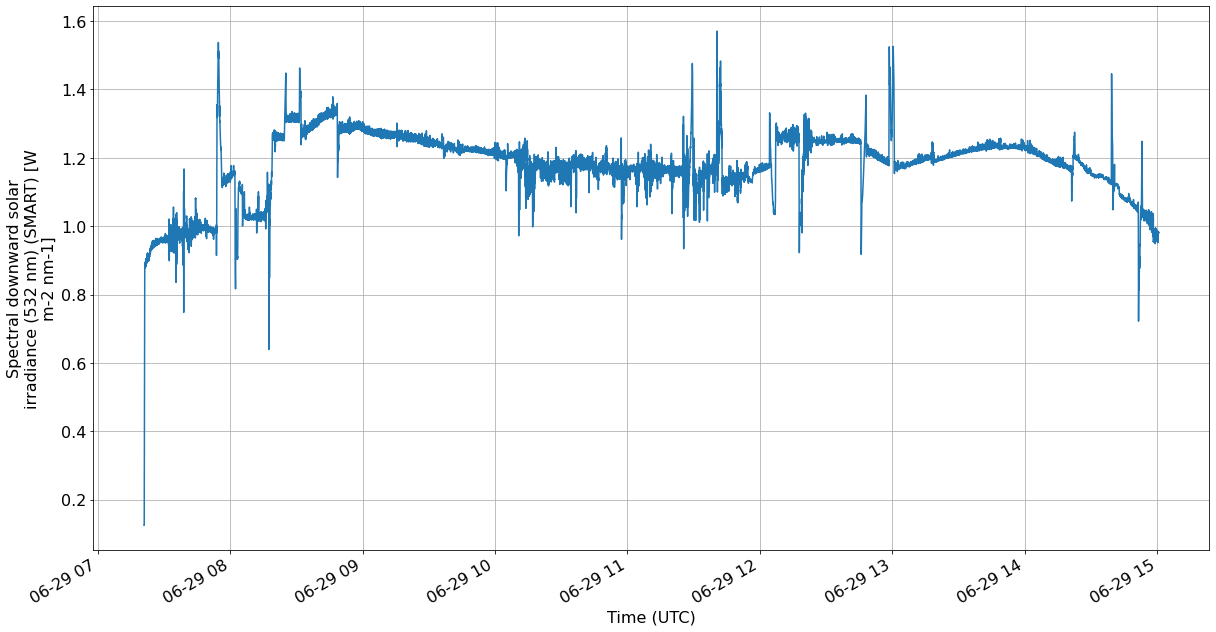

In [4]:
ds_halo_smart.F_down_solar_wl_532.plot()
plt.grid()
plt.xlabel("Time (UTC)")
plt.show()
plt.close()

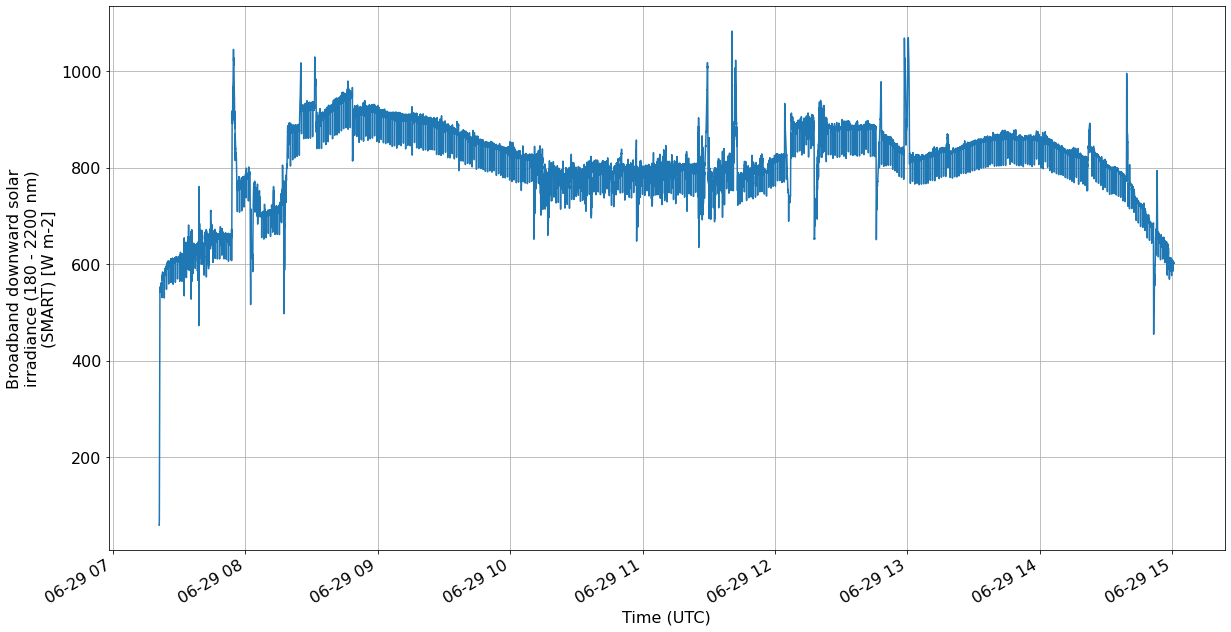

In [5]:
ds_halo_smart.F_down_solar_bb.plot()
plt.grid()
plt.xlabel("Time (UTC)")
plt.show()
plt.close()

In [6]:
# read in BAHAMAS data
ds_bahamas = read_bahamas(bahamas_file_path)
ds_bahamas

<xarray.Dataset>
Dimensions:    (time: 284170)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-29T07:04:42 ... 2021-06-29T14:58...
Data variables: (12/45)
    IGI_RMSX   (time) float32 ...
    IGI_RMSY   (time) float32 ...
    IGI_RMSZ   (time) float32 ...
    IRS_ALT    (time) float32 ...
    IRS_ATA    (time) float32 ...
    IRS_AXB    (time) float32 ...
    ...         ...
    TS         (time) float32 ...
    RELHUM     (time) float32 ...
    SOURCE     (time) float32 ...
    WS         (time) float32 ...
    MIXRATIOV  (time) float32 ...
    MIXRATIO   (time) float32 ...
Attributes: (12/19)
    title:                Quality controlled data of DLR measurment flight ad...
    aircraft:             D-ADLR
    project:              CIRRUS--HL
    mission:              CIRRUS--HL
    ProjectInvestigator:  Voigt
    flightname:           adlr_20210629a
    ...                   ...
    date_last_revised:    2021-6-30
    TimeInterval:         07:04:42 - 14:58:19
    comment:               Humidity is measured with SHARC and/or HUMICAP VAI...
    platform:             HALO
    instrument:           BAHAMAS
    Variablelist:          TIME IGI_RMSX IGI_RMSY IGI_RMSZ IRS_ALT IRS_ATA IR...

SMART and BAHAMAS both have a very high time resolution.
Let's resample SMART data to 1 second resolution and then select BAHAMAS time steps which are closest to HALO-SMART time steps.
This will take a few moments...

In [ ]:
ds_halo_smart = ds_halo_smart.resample(time="1s").mean()
ds_bahamas = ds_bahamas.sel(time=ds_halo_smart.time, method="nearest")
ds_bahamas

Use the BAHAMAS pitch and roll data to filter out high attitude angles from the data

In [ ]:
roll_filter = 5
pitch_filter = 3
attitude_filter = ((np.abs(ds_bahamas.IRS_PHI) < roll_filter) & (np.abs(ds_bahamas.IRS_THE) < pitch_filter)).values
# plot result together with motion angles
fig, ax = plt.subplots()
ds_bahamas.IRS_PHI.plot(ax=ax, label="Roll angle")
ds_bahamas.IRS_THE.plot(ax=ax, label="Pitch angle")
ax.fill_between(ds_bahamas.time.values, 0, 1, where=~attitude_filter, transform=ax.get_xaxis_transform(), label="Attitude Flag", color="red", alpha=0.5)
ax.set_ylim(-5, 5)
ax.grid()
ax.legend()
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Motion Angle (deg)")
ax.set_title(f"BAHAMAS Roll and Pitch Angle with Attitude Flag\nData flagged when roll > {roll_filter} and/or pitch > {pitch_filter}")
plt.show()
plt.close()

Plot HALO-SMART data with attitude flag

In [ ]:
x_sel = (pd.Timestamp(2021, 6, 29, 10), pd.Timestamp(2021, 6, 29, 12, 15))
fig, ax = plt.subplots()
ds_halo_smart.F_down_solar_bb.plot(ax=ax, label="HALO-SMART")
ax.fill_between(ds_halo_smart.time.values, 0, 1, where=~attitude_filter, transform=ax.get_xaxis_transform(), label="Attitude Flag", color="red", alpha=0.5)
ax.set_xlim(x_sel)
ax.grid()
ax.legend()
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Broadband Solar Downward Irradiance (W$\,$m$^{-2}$)")
plt.show()
plt.close()